In [8]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from textwrap import wrap
import networkx as nx


In [9]:
# url = "https://www.heste-nettet.dk/forum/1/1316128/1316128/"
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 

def get_html_content(url):
    # Check if the request was successful
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        # Parse the HTML content of the page with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    elif response.status_code == 404 or response.status_code == 403:
        print(f"Response code: {response.status_code} for {url}")
    else:
        return None


In [10]:

def author_text_scrape(soup):
    author_list = []
    text_list = []
    # Find all the <td> elements with class "light" and itemprop="text"
    td_elements = soup.find_all('td', bgcolor='#787878', valign='top')

    # Iterate through the <td> elements
    for td in td_elements:
        # Extract the author's href number
        author_a = td.find('a', itemprop='url')
        if author_a:
            author_href = author_a['href']
            author_text = author_a.text
            
        else:
            author_href = None
            author_text = td.find('span', itemprop='name').text
        # print(author_text)
        # Find the first <div> with class "rsPost" within the current <td>
        rs_post = td.find('div', class_='rsPost')
        
        if rs_post:
            # Extract Danish text within <span> tags
            danish_text = [span.text for span in rs_post.find_all('p')]
            
            # Combine the text into a single string
            danish_text = "\n".join(danish_text)
                
            # if len(danish_text)>1 and author_text:
                # author_list.append(author_href.split('/')[-2])
            author_list.append(author_text)
            text_list.append(danish_text)
        # if author_text == "Doctor Who" and len(author_list)<2:
        #     print(rs_post)

    return author_list, text_list


In [11]:
soup = get_html_content("https://www.heste-nettet.dk/forum/1/")
links = soup.find_all("a",href=True)
href_list = []
# Filter and print the links
for link in links:
    href = link['href']
    if "/forum/1/" in href and len(href.split("/"))==6:
        href_list.append(href)

In [12]:
authors_data = []
texts_data = []
used_href_list = []
for href in tqdm(href_list):
    url = f"https://www.heste-nettet.dk{href}"
    if (soup:=get_html_content(url)):
        author_list, text_list = author_text_scrape(soup)
        if len(author_list)>0 and len(text_list)>0:
            authors_data.append(author_list)
            texts_data.append(text_list)
            used_href_list.append(href)

100%|██████████| 70/70 [00:21<00:00,  3.30it/s]


In [13]:
authors_data

[['Nathalie O'],
 ['Kia B'],
 ['Isa V', 'Michael H (6)', 'Webarmen1', 'Webarmen1'],
 ['Camilla80',
  'Jeanette O',
  'Maja J',
  'Kariiinaen',
  'Metteweirsoe',
  'anima',
  'Team Pip (Helena)',
  'ridesteder',
  'Her...',
  'vibha',
  '£isbeth (Baloo)',
  'Ride steder',
  'Berit & Lukas',
  'Annecathrine',
  'Jeg har redet',
  'TheaDV',
  'Camilla80',
  'MetteLodberg',
  'Camilla80',
  'Camilla80',
  'kopsa',
  'De fleste...',
  'Sasser',
  'Vejle..',
  'Marianne Beck',
  'Jeg ved da',
  'mmmhhh',
  'Gitte Olsen',
  'KitSchouby',
  'Skingur',
  'westlife',
  'Hvor har jeg redet?',
  'Skingur',
  'Blomst og trolle<3',
  'Robsen',
  'Pia H.',
  'Alice Nielsen',
  'Line & Tatoo',
  'Pernilleblom',
  'Krohne',
  'Rideskoler',
  'LineG',
  'Winnie J',
  'Patricia',
  'Linnea (Jay-Jay og Figo)',
  'Linse *Dejó*',
  'Rideklubber',
  'Årstal??',
  'jepsem (marianne)',
  'Spirrevippen ♥Bianca♥',
  'hmm...',
  'boombastic ♥helena♥',
  'DortheL',
  'istebjerg',
  'lisbethdue',
  'silas',
  'Håhå

In [14]:
# Initialize a directed graph (DiGraph)
G = nx.DiGraph()

# Initialize a dictionary to store text lengths for each author
author_text_lengths = {}

# Keep track of added nodes
added_nodes = set()

# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):
    # The first author in the inner list is the OP author
    try:
        op_author = authors[0]
    except:
        print(idx, authors, text_sections)
        break
    
    # Add nodes for all authors, including the OP, and initialize the "OP_author" attribute to 0
    for author in authors:
        if author not in added_nodes:
            G.add_node(author, OP_author=0, reads=0,comments = 0)
            added_nodes.add(author)

    # Update the "OP_author" attribute for the OP author
    G.nodes[op_author]["OP_author"] += 1
    G.nodes[op_author]["reads"] += len(authors)-1

    # Connect the OP author to all other authors with weighted edges
    for author in authors[1:]:
        if G.has_edge(author, op_author):
            G[author][op_author]["weight"] += 1  # Increment the edge weight
        else:
            G.add_edge(author, op_author, weight=1)  # Initialize edge weight to 1
        
        G.nodes[author]["comments"] += 1

    # Calculate text lengths and store in the author_text_lengths dictionary
    for author, text_section in zip(authors, text_sections):
        text_length = len(text_section)
        author_text_lengths[author] = text_length


In [15]:
authors_data

[['Nathalie O'],
 ['Kia B'],
 ['Isa V', 'Michael H (6)', 'Webarmen1', 'Webarmen1'],
 ['Camilla80',
  'Jeanette O',
  'Maja J',
  'Kariiinaen',
  'Metteweirsoe',
  'anima',
  'Team Pip (Helena)',
  'ridesteder',
  'Her...',
  'vibha',
  '£isbeth (Baloo)',
  'Ride steder',
  'Berit & Lukas',
  'Annecathrine',
  'Jeg har redet',
  'TheaDV',
  'Camilla80',
  'MetteLodberg',
  'Camilla80',
  'Camilla80',
  'kopsa',
  'De fleste...',
  'Sasser',
  'Vejle..',
  'Marianne Beck',
  'Jeg ved da',
  'mmmhhh',
  'Gitte Olsen',
  'KitSchouby',
  'Skingur',
  'westlife',
  'Hvor har jeg redet?',
  'Skingur',
  'Blomst og trolle<3',
  'Robsen',
  'Pia H.',
  'Alice Nielsen',
  'Line & Tatoo',
  'Pernilleblom',
  'Krohne',
  'Rideskoler',
  'LineG',
  'Winnie J',
  'Patricia',
  'Linnea (Jay-Jay og Figo)',
  'Linse *Dejó*',
  'Rideklubber',
  'Årstal??',
  'jepsem (marianne)',
  'Spirrevippen ♥Bianca♥',
  'hmm...',
  'boombastic ♥helena♥',
  'DortheL',
  'istebjerg',
  'lisbethdue',
  'silas',
  'Håhå

In [16]:
# edge_weights = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
# for (u, v), weight in edge_weights.items():
#     print(f"Weight of edge between node {u} and node {v}: {weight}")

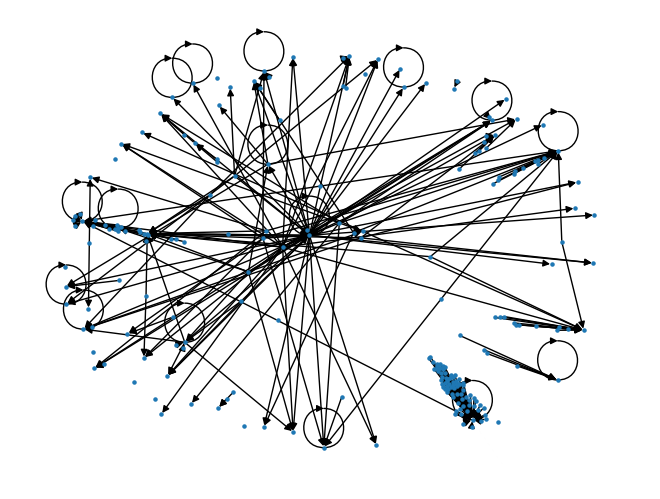

In [17]:
nx.draw(G,node_size=5)


In [18]:
# sorted(list(dict(G.in_degree).items()),key=lambda x: x[1],reverse=True)
# sorted(list(dict(G.out_degree).items()),key=lambda x: x[1],reverse=True)

In [19]:
# from pyvis.network import Network

# pyvis_graph = Network(notebook=True,cdn_resources='in_line')
# pyvis_graph.from_nx(G)
# pyvis_graph.show("graph.html")

In [20]:
# Collect edge weights into a list
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Normalize edge_weights
max_weight = max(edge_weights)
min_weight = min(edge_weights)
edge_weights_normalized = [(w - min_weight)/(max_weight - min_weight) for w in edge_weights]

# Initialize edge colors
edge_colors = []

for weight in edge_weights_normalized:
    edge_colors.extend([f'rgba(0,0,255,{weight})', f'rgba(0,0,255,{weight})', 'rgba(0,0,0,0)'])


In [21]:
# Layout
pos = nx.spring_layout(G)

# Collect edge weights into a list and normalize them
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Initialize list to store edge traces
edge_traces = []

# Loop through each edge to create an edge trace
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    # Get edge weight and normalize it
    weight = G.edges[edge]['weight']
    normalized_weight = (weight - min_weight) / (max_weight - min_weight)
    
    edge_color = f'rgba(0,0,255,{normalized_weight+0.1})'
    
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.5, color=edge_color),
        hoverinfo='none',
        mode='lines'
    )
    
    edge_traces.append(edge_trace)

# Nodes
node_x = []
node_y = []
node_text = []

node_reads = [G.nodes[node].get('reads', 0) for node in G.nodes()]
max_reads = max(node_reads)
min_reads = min(node_reads)
node_sizes = [(reads - min_reads)/(max_reads - min_reads) * 20 + 10 for reads in node_reads]


for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Sample node attributes (Replace this line with your actual node attributes)
    node_text.append(f'Node {node}<br>OP:{G.nodes[node]["OP_author"]}<br>Reads:{G.nodes[node]["reads"]}<br>Comments:{G.nodes[node]["comments"]}')

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    text=node_text,
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_sizes,  # Node sizes based on 'reads'
        colorbar=dict(
            thickness=15,
            title='Node Color Scale',
            xanchor='left',
            titleside='right'
        )
    )
)

# Create the final figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(
    height=800,
    width=1200
)

fig.show()

In [22]:
# fig.write_html("graph_export.html")

In [23]:
G.nodes()

NodeView(('Nathalie O', 'Kia B', 'Isa V', 'Michael H (6)', 'Webarmen1', 'Camilla80', 'Jeanette O', 'Maja J', 'Kariiinaen', 'Metteweirsoe', 'anima', 'Team Pip (Helena)', 'ridesteder', 'Her...', 'vibha', '£isbeth (Baloo)', 'Ride steder', 'Berit & Lukas', 'Annecathrine', 'Jeg har redet', 'TheaDV', 'MetteLodberg', 'kopsa', 'De fleste...', 'Sasser', 'Vejle..', 'Marianne Beck', 'Jeg ved da', 'mmmhhh', 'Gitte Olsen', 'KitSchouby', 'Skingur', 'westlife', 'Hvor har jeg redet?', 'Blomst og trolle<3', 'Robsen', 'Pia H.', 'Alice Nielsen', 'Line & Tatoo', 'Pernilleblom', 'Krohne', 'Rideskoler', 'LineG', 'Winnie J', 'Patricia', 'Linnea (Jay-Jay og Figo)', 'Linse *Dejó*', 'Rideklubber', 'Årstal??', 'jepsem (marianne)', 'Spirrevippen ♥Bianca♥', 'hmm...', 'boombastic ♥helena♥', 'DortheL', 'istebjerg', 'lisbethdue', 'silas', 'Håhåhåh', 'ddd', 'dressurtante', 'sarah-ann', 'Pauline ♥Cæsar♥', 'MiniBaah', 'suprise (Karina Serup Jensen)', 'Michelle Molin', 'juva ♥juva♥', 'Katrine elsker ♥Nicklas-Walle&#', 'C